# LSTM Neural Network Fitting Analysis

## Preamble

The aim of this analysis is to develop a pipeline that consists of a LSTM Neural Network (LSTM NN) that given the opening stock price of a stock over the previous 40 days, can accurately predict the current opening stock price.  This project was inspired by the work done by Yacoub Ahmed that can be found here https://towardsdatascience.com/getting-rich-quick-with-machine-learning-and-stock-market-predictions-696802da94fe.  The aim is while using his original LSTM NN as a starting point, is to improve it and then leverage it to create a simulation of some stock trading on a few automobile stocks.  In the interest of academic honesty, it must be noted that while we took our inspiration from Yacoub and used his original LSTM model, all code used here is original.

Note, in call cases where we train a LSTM NN, we have commented it out and replaced it with code that loads in the models from memory.  This is done to save the markers time from having to retrain the models.  Which I certainly do not recommend unless you have a GPU at your disposal.

In [18]:
# Reading in neccessary packages
from datetime import date, timedelta
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.utils import resample

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [19]:
data = pd.read_csv('Data/ford.csv', index_col='Date')

## Check for Reasonable Predictor

To begin, we will build our model on Ford stock from January 1st, 2000 to November 17, 2020 (The day I am creating this).  Lets first as a formality check that the daily opening stock price is actually correlated to the previous days opening stock price.  To check this, we will create a plot of the sample correlation (ACF) below.  If we examine the AF plot below, we can clearly see that the opening price is highly correlated to the previous days opening stock price.  We can actually see this continues for many lags k.  Of course the reader may be wondering what we mean by lag k?  Let the opening stock price of ford be represented by the time series process ${Y_t}$.  The current days opening stock price we are interested in can be denated as $Y_t$.  Then in the plot below we can a high correlation between $Y_t$ and $Y_{t-k}$ where k is some integer k that denotes some number of units back in time.  For instance, from the plot below we can see that the sample ACF between $Y_t$ and $Y_{t-2}$ produces a sample ACF very close to 1.  Moving on, our conclusion from this plot is simply that the current opening stock price of Ford has a high correlation with its past opening stock prices.  Thus, it could be a strong predictor.  Lastly, the question remains how far back in the past to predict the current opening stock price.  That is many many past days should we use to predict the current day.  To choose this we arbitrarilty chose 4.

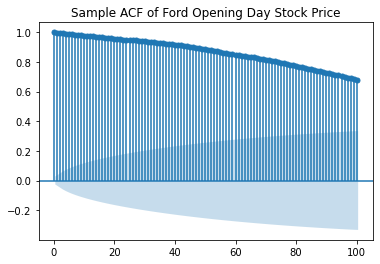

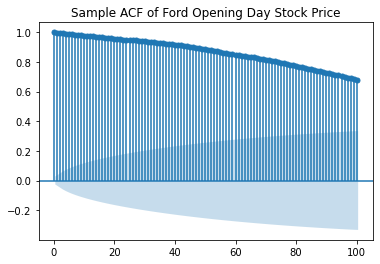

In [20]:
# CITATION: https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711
plot_acf(data['Open'], lags=100, title='Sample ACF of Ford Opening Day Stock Price')

# NOTE: for some reason this produces 2 of the same plot, it could not be removed.

## Set Up Code

The following few cells contain code that will be use to create, and evaluate the models

In [21]:
# This defines the numpy of days in the past we will use to predict the current price
LAG = 40

In [22]:
# Plots the results of a mode.
def plot(yHat, y, title):
    plt.plot(y)
    plt.plot(yHat)
    plt.legend(['Real', 'Predicted'])
    plt.title(title)
    plt.show()
    

In [23]:
# Calculates the MSE
def mse(x, y):
    preds = model.predict(x)
    preds = scaler.inverse_transform(preds)
    unscaled_yTest = scaler.inverse_transform(np.reshape(y, (-1, 1)))
    return np.mean(np.square(preds-unscaled_yTest)), preds, unscaled_yTest

In [24]:
# This function accepts the raw data and transforms it into the form required for the LSTM NN.  
# - It removes unneccessary columns
# - scales the data between 0 and 1
# - transforms into numpy arrays
def transform(df, n=40):
    df = pd.DataFrame(df['Open'])  # Removing all the other columns as we are only predicting if we should buy based on the opening stock price

    
    # Normalizing to 0-1 range
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df)
    df = pd.DataFrame(scaler.transform(df), columns=df.columns, index=pd.to_datetime(df.index))


    # Creating 40 columns that give the past 40 day opening stock price
    for i in range(1, n + 1):
        df[f'Open-{i}'] = df['Open'].shift(i)

    # Subsetting for the neccessary columns
    df = df.iloc[40:, 0:]

    # Splitting into training and testing data (test size is about last 2 years)
    dt = pd.to_datetime(date(2020, 11, 17) - timedelta(days=730))
    train = df[df.index < dt]
    test = df[df.index >= dt]     

    # Splitting into appropriat x and y values
    xTrain = train.iloc[:, 1:]
    yTrain = train.iloc[:, 0]
    xTest = test.iloc[:, 1:]
    yTest = test.iloc[:, 0]

    # Converting to numpy arrays to feed into model
    xTrain = xTrain.to_numpy()
    yTrain = yTrain.to_numpy()
    xTest = xTest.to_numpy()
    yTest = yTest.to_numpy()

    # Reshaping to get correct form
    xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
    xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

    return xTrain, yTrain, xTest, yTest, scaler

In [8]:
def saveModel(model, name, location='Data'):
    # CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # serialize model to JSON
    model_json = model.to_json()
    with open(f"{location}/{name}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{location}/{name}.h5")
    print("Saved model to disk")

def loadModel(name, location='Data'):
    # CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # load json and create model
    json_file = open(f"{location}/{name}.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(f"{location}/{name}.h5")
    return model
    print("Loaded model from disk")



In [9]:
xTrain, yTrain, xTest, yTest, scaler = transform(data, LAG)

In [10]:
# Setting the batch size for the model.
BATCH_SIZE = int(xTrain.shape[0]/3)
# BATCH_SIZE = xTrain.shape[0]

In [11]:
def modelTraining(epoch, batchSize, neuronsLSTM1=50,neuronsLSTM2=128, neuronsDense=64, learningRate=0.0005):
    with tf.device("gpu:0"):
        model = Sequential()
        model.add(LSTM(neuronsLSTM1,input_shape=(xTrain.shape[1],xTrain.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(neuronsDense))
        model.add(Activation('sigmoid'))
        model.add(Dense(1))
        model.add(Activation('linear'))
        opt = tf.keras.optimizers.Adam(lr=learningRate)
        model.compile(optimizer=opt, loss='mse')
        model.fit(xTrain,yTrain, batch_size=batchSize, epochs=epoch, shuffle=True)
    return model

## Model Training

### Model Tuning 1: Batch Size

Using our model as defined above, we explore the affect of batch sizes using of 10, 32(Default), 100, 500, 1000, 1500, and 2000.  All with a standard of 1000 epochs.

In [12]:
# batches = pd.DataFrame(columns=['batchSize', 'mseTrain','mseTest'])
# for batchSize in [10,32 ,100, 500, 1000, 1500, 2000, 2500, 3000]:
#     model = modelTraining(1000, batchSize)
#     mseTrain, yHat, y = mse(xTrain,yTrain)
#     mseTest, yHat, y = mse(xTest,yTest)
#     batches = batches.append({'batchSize':batchSize, 'mseTrain': mseTrain, 'mseTest':mseTest}, ignore_index=True)

#     saveModel(model, f"fordBatchTraining{batchSize}", location='Data')

# batches.to_csv('Data/fordBatchTraining.csv')

results = pd.read_csv('Data/fordBatchTraining.csv')
results
    


,batchSize,mseTrain,mseTest
0,10,0.053750,0.007168
1,32,0.069077,0.006059
2,100,0.096221,0.005149
3,500,0.135626,0.013121
4,1000,0.181391,0.006829
5,1500,0.246180,0.010500
6,2000,0.363314,0.035387
7,2500,0.421914,0.046237
8,3000,0.215748,0.005812


Looking at the above results of changing the batch size, we see mixed results with the potential that our predictions get worse as we increase the batch size.  We can see this as the MSof the training data does appear to increase as our batch size increases.  To verify the results, lets plot the results of the models with a batch size 10, 2000 and 3000 respectively.

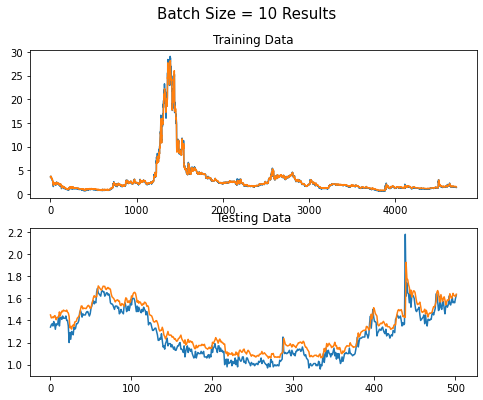

In [14]:
model = loadModel(name='fordBatchTraining10')


# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Batch Size = 10 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")

meanSquared, yHat, y = mse(xTest,yTest)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")

plt.show()

0.36331427200357713
0.035387185616672805


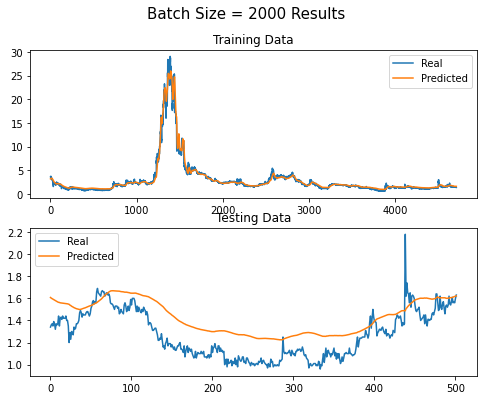

In [15]:
model = loadModel(name='fordBatchTraining2000')
# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Batch Size = 2000 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

0.21574778866367464
0.00581204641572969


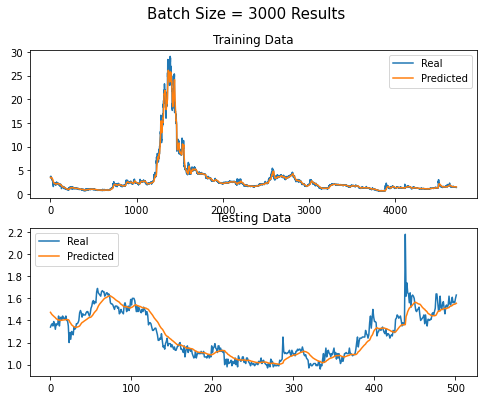

In [16]:
model = loadModel(name='fordBatchTraining3000')
# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Batch Size = 3000 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

We can clearly see that as the batch sizes increases, the fit of the model on the testing data worsens significantly.  This is particularly interesting for the batch size = 3000 where the testing MSE is actually quite good, but the training MSE is poor.  Ultimatly, we conclude that a smaller batch size is best.

### Model Tuning 2: Epochs

To achieve a better fit, we will now try to tune the number of epochs the model must iterate through to train the model.  To do so we will try epochs of 50, 100, 500, 1000, 2000, and 3000.  Using our results from tuning the batch size, we will use a constant batch size of 10.

In [26]:
# batches = pd.DataFrame(columns=['epochs', 'mseTrain','mseTest'])
# for epoch in [50,100, 500, 1000, 2000, 3000]:
#     model = modelTraining(epoch, 10)
#     mseTrain, yHat, y = mse(xTrain,yTrain)
#     mseTest, yHat, y = mse(xTest,yTest)
#     batches = batches.append({'epochs':epoch, 'mseTrain': mseTrain, 'mseTest':mseTest}, ignore_index=True)

#     saveModel(model, f"fordEpochTraining{epoch}", location='Data')

# batches.to_csv('Data/fordEpochTraining.csv')

results = pd.read_csv('Data/fordEpochTraining.csv')
results
    

,epochs,mseTrain,mseTest
0,50,0.914686,0.362143
1,100,0.267374,0.044504
2,500,0.128154,0.052861
3,1000,0.054909,0.003233
4,2000,0.026806,0.004708
5,3000,0.139692,0.008902


Looking at the results of increasing the number of epochs in our model, we can clearly see that increasing it reduces the MSE of both the training and test data.  However, we can see that after 1000 epochs the decreases dimish and in fact increases for the epoch=3000.  To investigate further, lets plots the results.

0.9146856378208328
0.3621430746025449


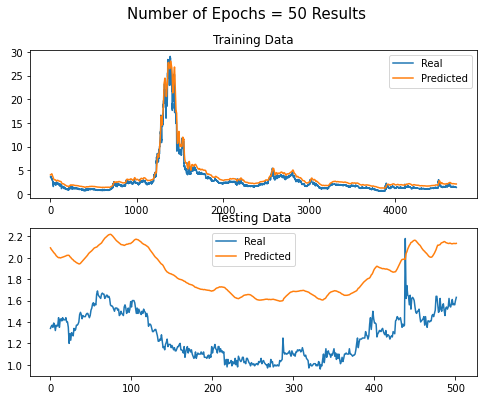

In [28]:
model = loadModel(name='fordEpochTraining50')
# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Number of Epochs = 50 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

0.026805853110043028
0.004708414955350479


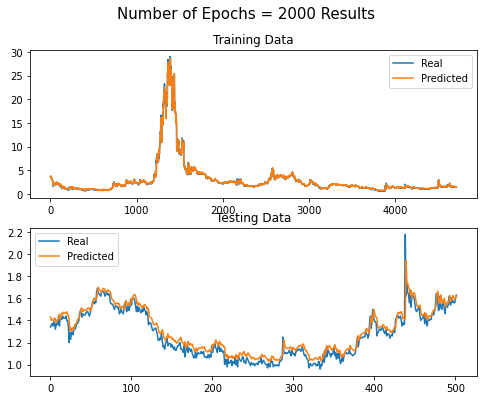

In [33]:
model = loadModel(name='fordEpochTraining2000')
# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Number of Epochs = 2000 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

0.13969178935393936
0.008901925384064287


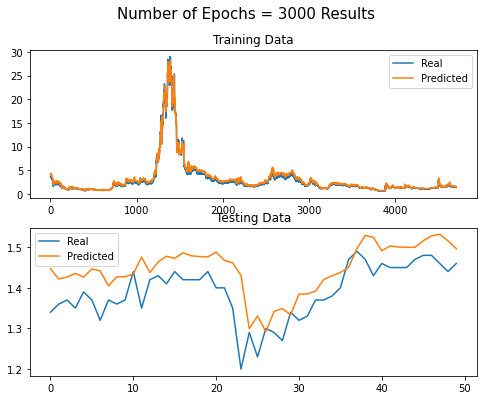

In [17]:
model = loadModel(name='fordEpochTraining3000')
# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Number of Epochs = 3000 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

We can clearly see that for epochs=50, the model is far away from the test data.  It is likely that it is simply undertrained.  For epochs=2000 and 3000, we see our predictions get much closer to the truth.  However for epochs=3000, our predictions appear to start deviating from the truth, perhaps it is now overtrained.  Thus, we will use epochs=2000 going forward.

### Model Tuning 3: Learning Rate


In [ ]:
def modelTraining(epoch, batchSize, neuronsLSTM1=50, neuronsDense=64, learningRate=0.0005):
    with tf.device("gpu:0"):
        model = Sequential()
        model.add(LSTM(neuronsLSTM1,input_shape=(xTrain.shape[1],xTrain.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(neuronsDense))
        model.add(Activation('sigmoid'))
        model.add(Dense(1))
        model.add(Activation('linear'))
        opt = tf.keras.optimizers.Adam(lr=learningRate)
        model.compile(optimizer=opt, loss='mse')
        model.fit(xTrain,yTrain, batch_size=batchSize, epochs=epoch, shuffle=True)
    return model

cvModels = pd.DataFrame(columns=['epochs', 'batch','neuronsLSTM','neuronsDense','learningRate','mseTrain','mseTest'])
for epoch in [50, 100, 500, 1000, 2000, 3000]:
    for batch in [10, 32, 100, 500, 1000, 2000]:
        for neuronsLSTM in [20, 40, 80, 100]:
            for neuronsDense in [20, 40, 80, 100]:
                for learningRate in [0.5, 0.05, 0.005, 0.0005,0.00005,0.000005]:
                    model = modelTraining(epoch, batch, neuronsLSTM, neuronsDense, learningRate)
                    mseTrain, yHat, y = mse(xTrain,yTrain)
                    mseTest, yHat, y = mse(xTest,yTest)
                    cvModels = cvModels.append({'epochs':epoch, 
                                                'batch':batch,
                                                'neuronsLSTM':neuronsLSTM,
                                                'neuronsDense':neuronsDense,
                                                'learningRate':learningRate,
                                                'mseTrain':mseTrain,
                                                'mseTest':mseTest}, ignore_index=True)
                    saveModel(model, f"fordCVTraining_{epoch}_{batch}_{neuronsLSTM}_{neuronsDense}_{learningRate}", location='Data')
                    
cvModels.to_csv('cvModelsResult.csv')


                    
        

Epoch 1/50
472/472 [==============================] - 4s 5ms/step - loss: 1.4705
Epoch 2/50
472/472 [==============================] - 2s 5ms/step - loss: 0.0204
Epoch 3/50
472/472 [==============================] - 2s 5ms/step - loss: 0.0216
Epoch 4/50
472/472 [==============================] - 2s 5ms/step - loss: 0.0233
Epoch 5/50
472/472 [==============================] - 2s 5ms/step - loss: 0.0240
Epoch 6/50
472/472 [==============================] - 2s 5ms/step - loss: 0.0227
Epoch 7/50
472/472 [==============================] - 2s 5ms/step - loss: 0.0228
Epoch 8/50
472/472 [==============================] - 2s 5ms/step - loss: 0.0269
Epoch 9/50
472/472 [==============================] - 2s 5ms/step - loss: 0.0244
Epoch 10/50
472/472 [==============================] - 2s 5ms/step - loss: 0.0289
Epoch 11/50
472/472 [==============================] - 2s 5ms/step - loss: 0.0277
Epoch 12/50
472/472 [==============================] - 2s 5ms/step - loss: 0.0262
Epoch 13/50
472/472 [====